## Clustering and Decision Trees

### Dataset: Marketing in Banking

Source: https://www.kaggle.com/janiobachmann/bank-marketing-dataset

(Original source: https://archive.ics.uci.edu/ml/datasets/bank+marketing)

#### Input variables:

##### bank client data:
 1. age (numeric)
 2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
 3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
 4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
 5. default: has credit in default? (categorical: 'no','yes','unknown')
 6. housing: has housing loan? (categorical: 'no','yes','unknown')
 7. loan: has personal loan? (categorical: 'no','yes','unknown')

##### related with the last contact of the current campaign:
 8. contact: contact communication type (categorical: 'cellular','telephone') 
 9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
 11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### other attributes:
 12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
 14. previous: number of contacts performed before this campaign and for this client (numeric)
 15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### social and economic context attributes
 16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
 17. cons.price.idx: consumer price index - monthly indicator (numeric) 
 18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
 19. euribor3m: euribor 3 month rate - daily indicator (numeric)
 20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
 21. y - has the client subscribed a term deposit? (binary: 'yes','no')
 
### Tasks

- Explore clustering algorithms on the dataset
- Fit a decision tree on the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../../data/bank-marketing/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
target = 'deposit'
features = df.columns[df.columns != target]

## Data cleaning

In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

No NaN values to clean!

But there are quite a few categorical features to convert to encode.

## Categorical data encoding

In [6]:
df[features].dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [7]:
for f in features:
    if (df[f].dtypes == 'object'):
        print(f, df[f].unique())

job ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital ['married' 'single' 'divorced']
education ['secondary' 'tertiary' 'primary' 'unknown']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome ['unknown' 'other' 'failure' 'success']


For simplicity, let's label encode these categorical features.

How to one-hot encode, for reference:
```
pd.get_dummies(df['marital'])
```

In [8]:
from sklearn.preprocessing import LabelEncoder

# store encoders in a dictionary so that we can refer to them easily for using / saving / loading
encoders = dict()

for f in features:
    if (df[f].dtypes == 'object'):
        encoder = LabelEncoder()
        encoder.fit(df[f])        
        df[f] = encoder.transform(df[f])
        encoders[f] = encoder

In [9]:
# inspect the encoders
encoders

{'job': LabelEncoder(),
 'marital': LabelEncoder(),
 'education': LabelEncoder(),
 'default': LabelEncoder(),
 'housing': LabelEncoder(),
 'loan': LabelEncoder(),
 'contact': LabelEncoder(),
 'month': LabelEncoder(),
 'poutcome': LabelEncoder()}

In [10]:
# inspect the encoded classes
for k, v in encoders.items():
    print(k, df[k].unique(), v.classes_)

job [ 0  9  7  4  5  1 10  2  3 11  6  8] ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital [1 2 0] ['divorced' 'married' 'single']
education [1 2 0 3] ['primary' 'secondary' 'tertiary' 'unknown']
default [0 1] ['no' 'yes']
housing [1 0] ['no' 'yes']
loan [0 1] ['no' 'yes']
contact [2 0 1] ['cellular' 'telephone' 'unknown']
month [ 8  6  5  1 10  9  2  4  3  7  0 11] ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome [3 1 0 2] ['failure' 'other' 'success' 'unknown']


Let's encode the target as well.

Since target encoders are generally used for decoding predictions, we will keep it separate from the feature encoders.

In [11]:
y_encoder = LabelEncoder()
y_encoder.fit(df[target])
df[target] = y_encoder.transform(df[target])

print(target, df[target].unique(), y_encoder.classes_)

deposit [1 0] ['no' 'yes']


## Data exploration

In [12]:
df.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
age,1.000000,-0.031603,-0.442782,-0.126018,-0.011425,0.112300,-0.168700,-0.031418,0.027762,-0.000762,-0.026130,0.000189,-0.005278,0.002774,0.020169,-0.002699,0.034901
job,-0.031603,1.000000,0.078314,0.147046,-0.007066,0.028736,-0.136965,-0.067092,-0.087915,0.026589,-0.076011,0.002432,0.003104,-0.003385,0.012665,-0.004238,0.063395
marital,-0.442782,0.078314,1.000000,0.125845,-0.014691,-0.002138,-0.036345,-0.062029,-0.060456,-0.003642,-0.004070,0.006781,-0.030794,0.031200,0.031281,-0.039424,0.067610
education,-0.126018,0.147046,0.125845,1.000000,-0.010709,0.051728,-0.109168,-0.073154,-0.132540,0.016759,-0.055868,-0.019122,-0.005327,0.025165,0.022427,-0.040262,0.095948
default,-0.011425,-0.007066,-0.014691,-0.010709,1.000000,-0.060954,0.011076,0.076434,0.035709,0.017342,0.000950,-0.009760,0.030975,-0.036282,-0.035273,0.042357,-0.040680
balance,0.112300,0.028736,-0.002138,0.051728,-0.060954,1.000000,-0.077092,-0.084589,-0.027295,0.010467,0.007264,0.022436,-0.013894,0.017411,0.030805,-0.027151,0.081129
housing,-0.168700,-0.136965,-0.036345,-0.109168,0.011076,-0.077092,1.000000,0.076761,0.226392,-0.014770,0.219602,0.035051,0.006660,0.064497,-0.000840,-0.046370,-0.203888
loan,-0.031418,-0.067092,-0.062029,-0.073154,0.076434,-0.084589,0.076761,1.000000,0.006829,0.017269,0.025329,-0.001914,0.034722,-0.030416,-0.022668,0.026344,-0.110580
contact,0.027762,-0.087915,-0.060456,-0.132540,0.035709,-0.027295,0.226392,0.006829,1.000000,0.007943,0.289803,-0.018000,0.059258,-0.227785,-0.169919,0.257993,-0.249847
day,-0.000762,0.026589,-0.003642,0.016759,0.017342,0.010467,-0.014770,0.017269,0.007943,1.000000,-0.019840,-0.018511,0.137007,-0.077232,-0.058981,0.080221,-0.056326


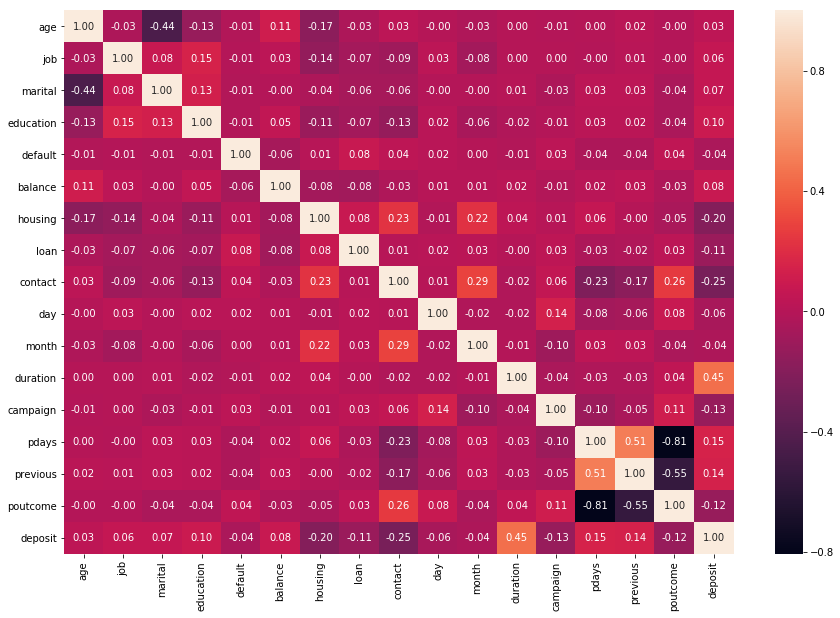

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax)

## Data visualisation using PCA

In [14]:
# check ranges to see if we need to scale before PCA
df[features].describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,4.487905,1.199337,1.285164,0.015051,1528.538524,0.473123,0.130801,0.489697,15.658036,5.445709,371.993818,2.508421,51.330407,0.832557,2.477782
std,11.913369,3.225132,0.625552,0.749478,0.121761,3225.413326,0.499299,0.337198,0.818724,8.420740,3.191939,347.128386,2.722077,108.758282,2.292007,1.002952
min,18.000000,0.000000,0.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,1.000000,1.000000,1.000000,0.000000,122.000000,0.000000,0.000000,0.000000,8.000000,3.000000,138.000000,1.000000,-1.000000,0.000000,2.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,550.000000,0.000000,0.000000,0.000000,15.000000,6.000000,255.000000,2.000000,-1.000000,0.000000,3.000000
75%,49.000000,7.000000,2.000000,2.000000,0.000000,1708.000000,1.000000,0.000000,1.000000,22.000000,8.000000,496.000000,3.000000,20.750000,1.000000,3.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,81204.000000,1.000000,1.000000,2.000000,31.000000,11.000000,3881.000000,63.000000,854.000000,58.000000,3.000000


C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[Text(0,0.5,'Z[1]'), Text(0.5,0,'Z[0]'), Text(0.5,1,'2-d PCA plot')]

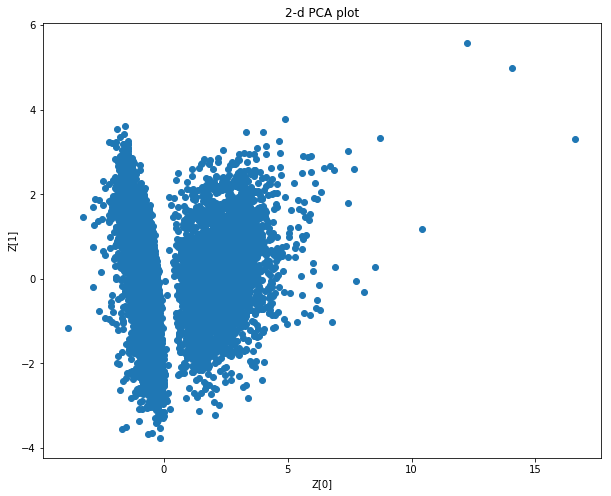

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scale for plotting purposes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# pca for plotting purposes
pca_2d = PCA(n_components=2)
Z_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1])
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot')

[Text(0,0.5,'Z[1]'), Text(0.5,0,'Z[0]'), Text(0.5,1,'2-d PCA plot')]

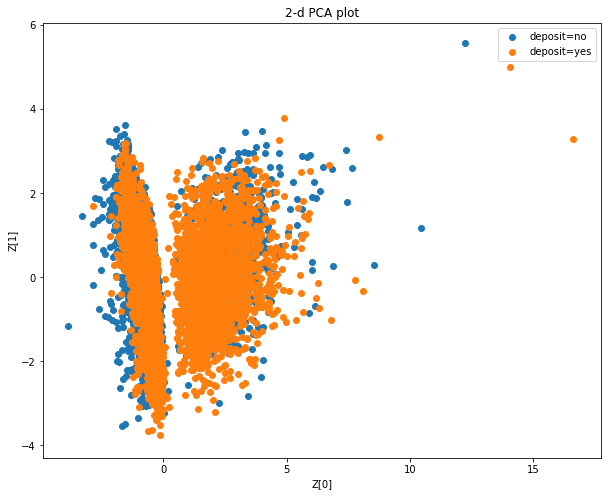

In [16]:
# If we take the labels into account, let's see how the data is separated

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(Z_2d[df[target] == 0, 0], Z_2d[df[target] == 0, 1], label='deposit=no')
ax.scatter(Z_2d[df[target] == 1, 0], Z_2d[df[target] == 1, 1], label='deposit=yes')
ax.legend()
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot')

Ah... overlapping classes.

Anyway, we'll leave this until the later (supervised) part of this workshop.

Let's continue with clustering (unsupervised).

In [17]:
pca_2d.explained_variance_ratio_.sum()

0.25398828128830164

## Clustering

At this point, the features can be clustered.  We'll try:

- K-means, including finding k using elbow plot
- Hierarchical clustering

In [18]:
X = df[features]

# let's fit another scaler here, to avoid confusion with the PCA plotting code above
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### K-means and Elbow Plot

In [19]:
from sklearn.cluster import KMeans

inertias = dict()

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    inertias[k] = kmeans.inertia_

[Text(0,0.5,'inertia'), Text(0.5,0,'n_clusters'), Text(0.5,1,'Elbow plot')]

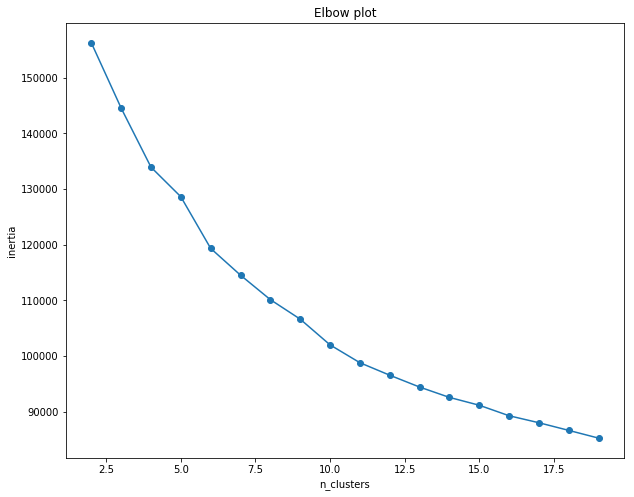

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(inertias.keys(), inertias.values(), marker='o')
ax.set(title='Elbow plot', xlabel='n_clusters', ylabel='inertia')

In [21]:
# Try k = 7, k = 2, etc

k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

[Text(0,0.5,'Z[1]'),
 Text(0.5,0,'Z[0]'),
 Text(0.5,1,'2-d PCA plot of clusters (k-means)')]

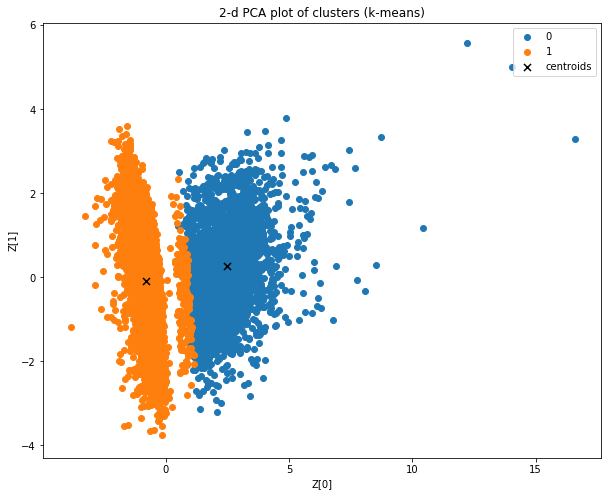

In [22]:
# Visualise
centroids_2d = pca_2d.transform(centroids)

fig, ax = plt.subplots(figsize=(10, 8))

# Colour the plot according to clusters
for i in range(k):
    ax.scatter(Z_2d[clusters == i, 0], Z_2d[clusters == i, 1], label=i)

# Mark the centroids
ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='x', color='black', label='centroids', s=50)

ax.legend()
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot of clusters (k-means)')

In [23]:
# Evaluate using homogeniety, completeness, and v-measure

from sklearn.metrics import homogeneity_completeness_v_measure

# homogeneity : float
#   score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

# completeness : float
#   score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling

# v_measure : float
#    harmonic mean of the first two
homogeneity_completeness_v_measure(df[target], clusters)

(0.03157673689707766, 0.03966010831947531, 0.03515980534810863)

### Hierarchical Clustering

In [24]:
# for visualisation
from scipy.cluster.hierarchy import dendrogram, linkage

# for doing the clustering
from sklearn.cluster import AgglomerativeClustering

[Text(0,0.5,'Inter-cluster distance'), Text(0.5,1,'Dendrogram')]

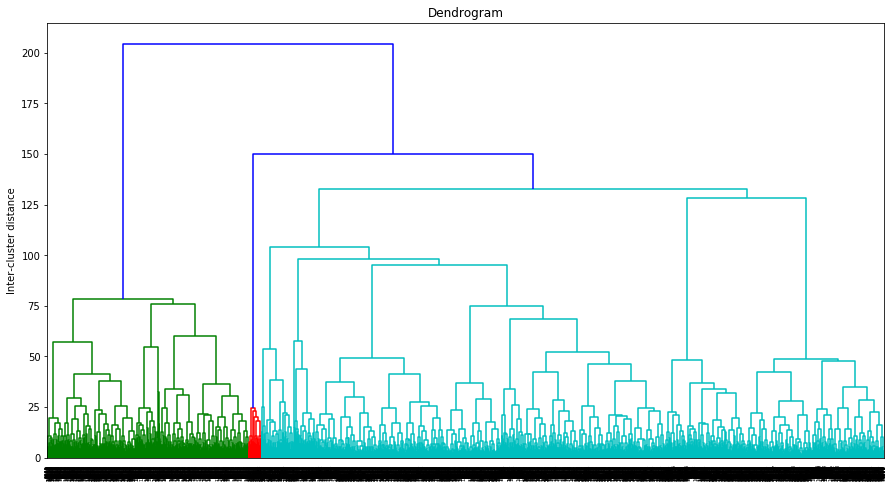

In [25]:
# Note: may take a while to run due to number of samples
links = linkage(X_scaled, 'ward')

fig, ax = plt.subplots(figsize=(15, 8))
dendrogram(links, ax=ax)

ax.set(title='Dendrogram', ylabel='Inter-cluster distance')

In [26]:
# Hierachical clustering seems to suggest a k of 3
k = 2 # try k = 3, k = 2, ...

agc = AgglomerativeClustering(n_clusters=k)
clusters_agc = agc.fit_predict(X_scaled)

[Text(0,0.5,'Z[1]'),
 Text(0.5,0,'Z[0]'),
 Text(0.5,1,'2-d PCA plot of clusters (hierarchical)')]

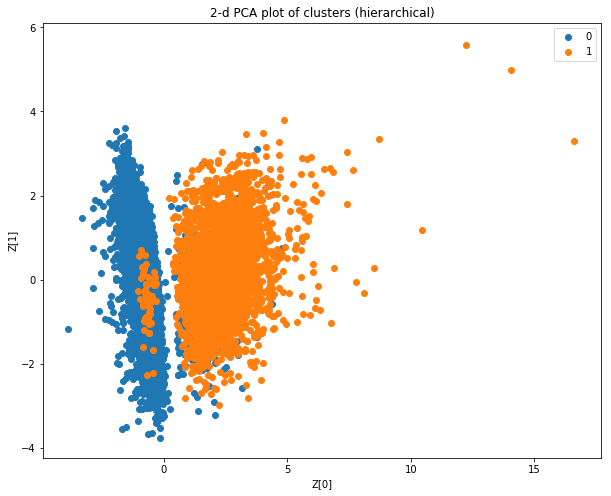

In [27]:
# Visualise

# Note that hierarchical clustering does not have the notion of centroids
# it's based on inter-cluster distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colour the plot according to clusters
for i in range(k):
    ax.scatter(Z_2d[clusters_agc == i, 0], Z_2d[clusters_agc == i, 1], label=i)

ax.legend()
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot of clusters (hierarchical)')

In [28]:
# Evaluation: hierachical clustering seems to do slightly better
homogeneity_completeness_v_measure(df[target], clusters_agc)

(0.03326877408544948, 0.0416683346144734, 0.036997808825449306)

### Exploring the clusters

Let's explore the clusters using correlation and scatter matrix to see if we discover patterns.

In [29]:
k = 4 # this is tunable as you explore clusters

kmeans = KMeans(n_clusters=k)
clusters_kmeans = kmeans.fit_predict(X_scaled)

agc = AgglomerativeClustering(n_clusters=k)
clusters_agc = agc.fit_predict(X_scaled)

In [30]:
# concat the original (unscaled) features and the predicted clusters in 1 dataframe
# (correlation is scale-invariant, meaning it is not affected by scaling)

df_kmeans = pd.concat([df[features], pd.DataFrame(clusters_kmeans, index=df.index,
                                                  columns=['cluster_id'])], axis=1)
df_kmeans.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,cluster_id
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,0
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,0
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,0
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,0
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,0


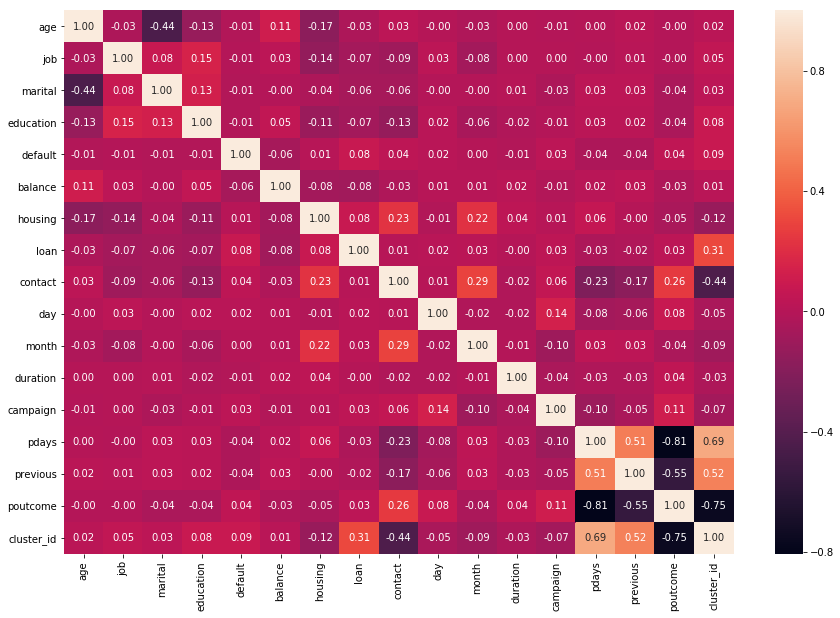

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_kmeans.corr(), annot=True, fmt='.2f', ax=ax)

C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invali

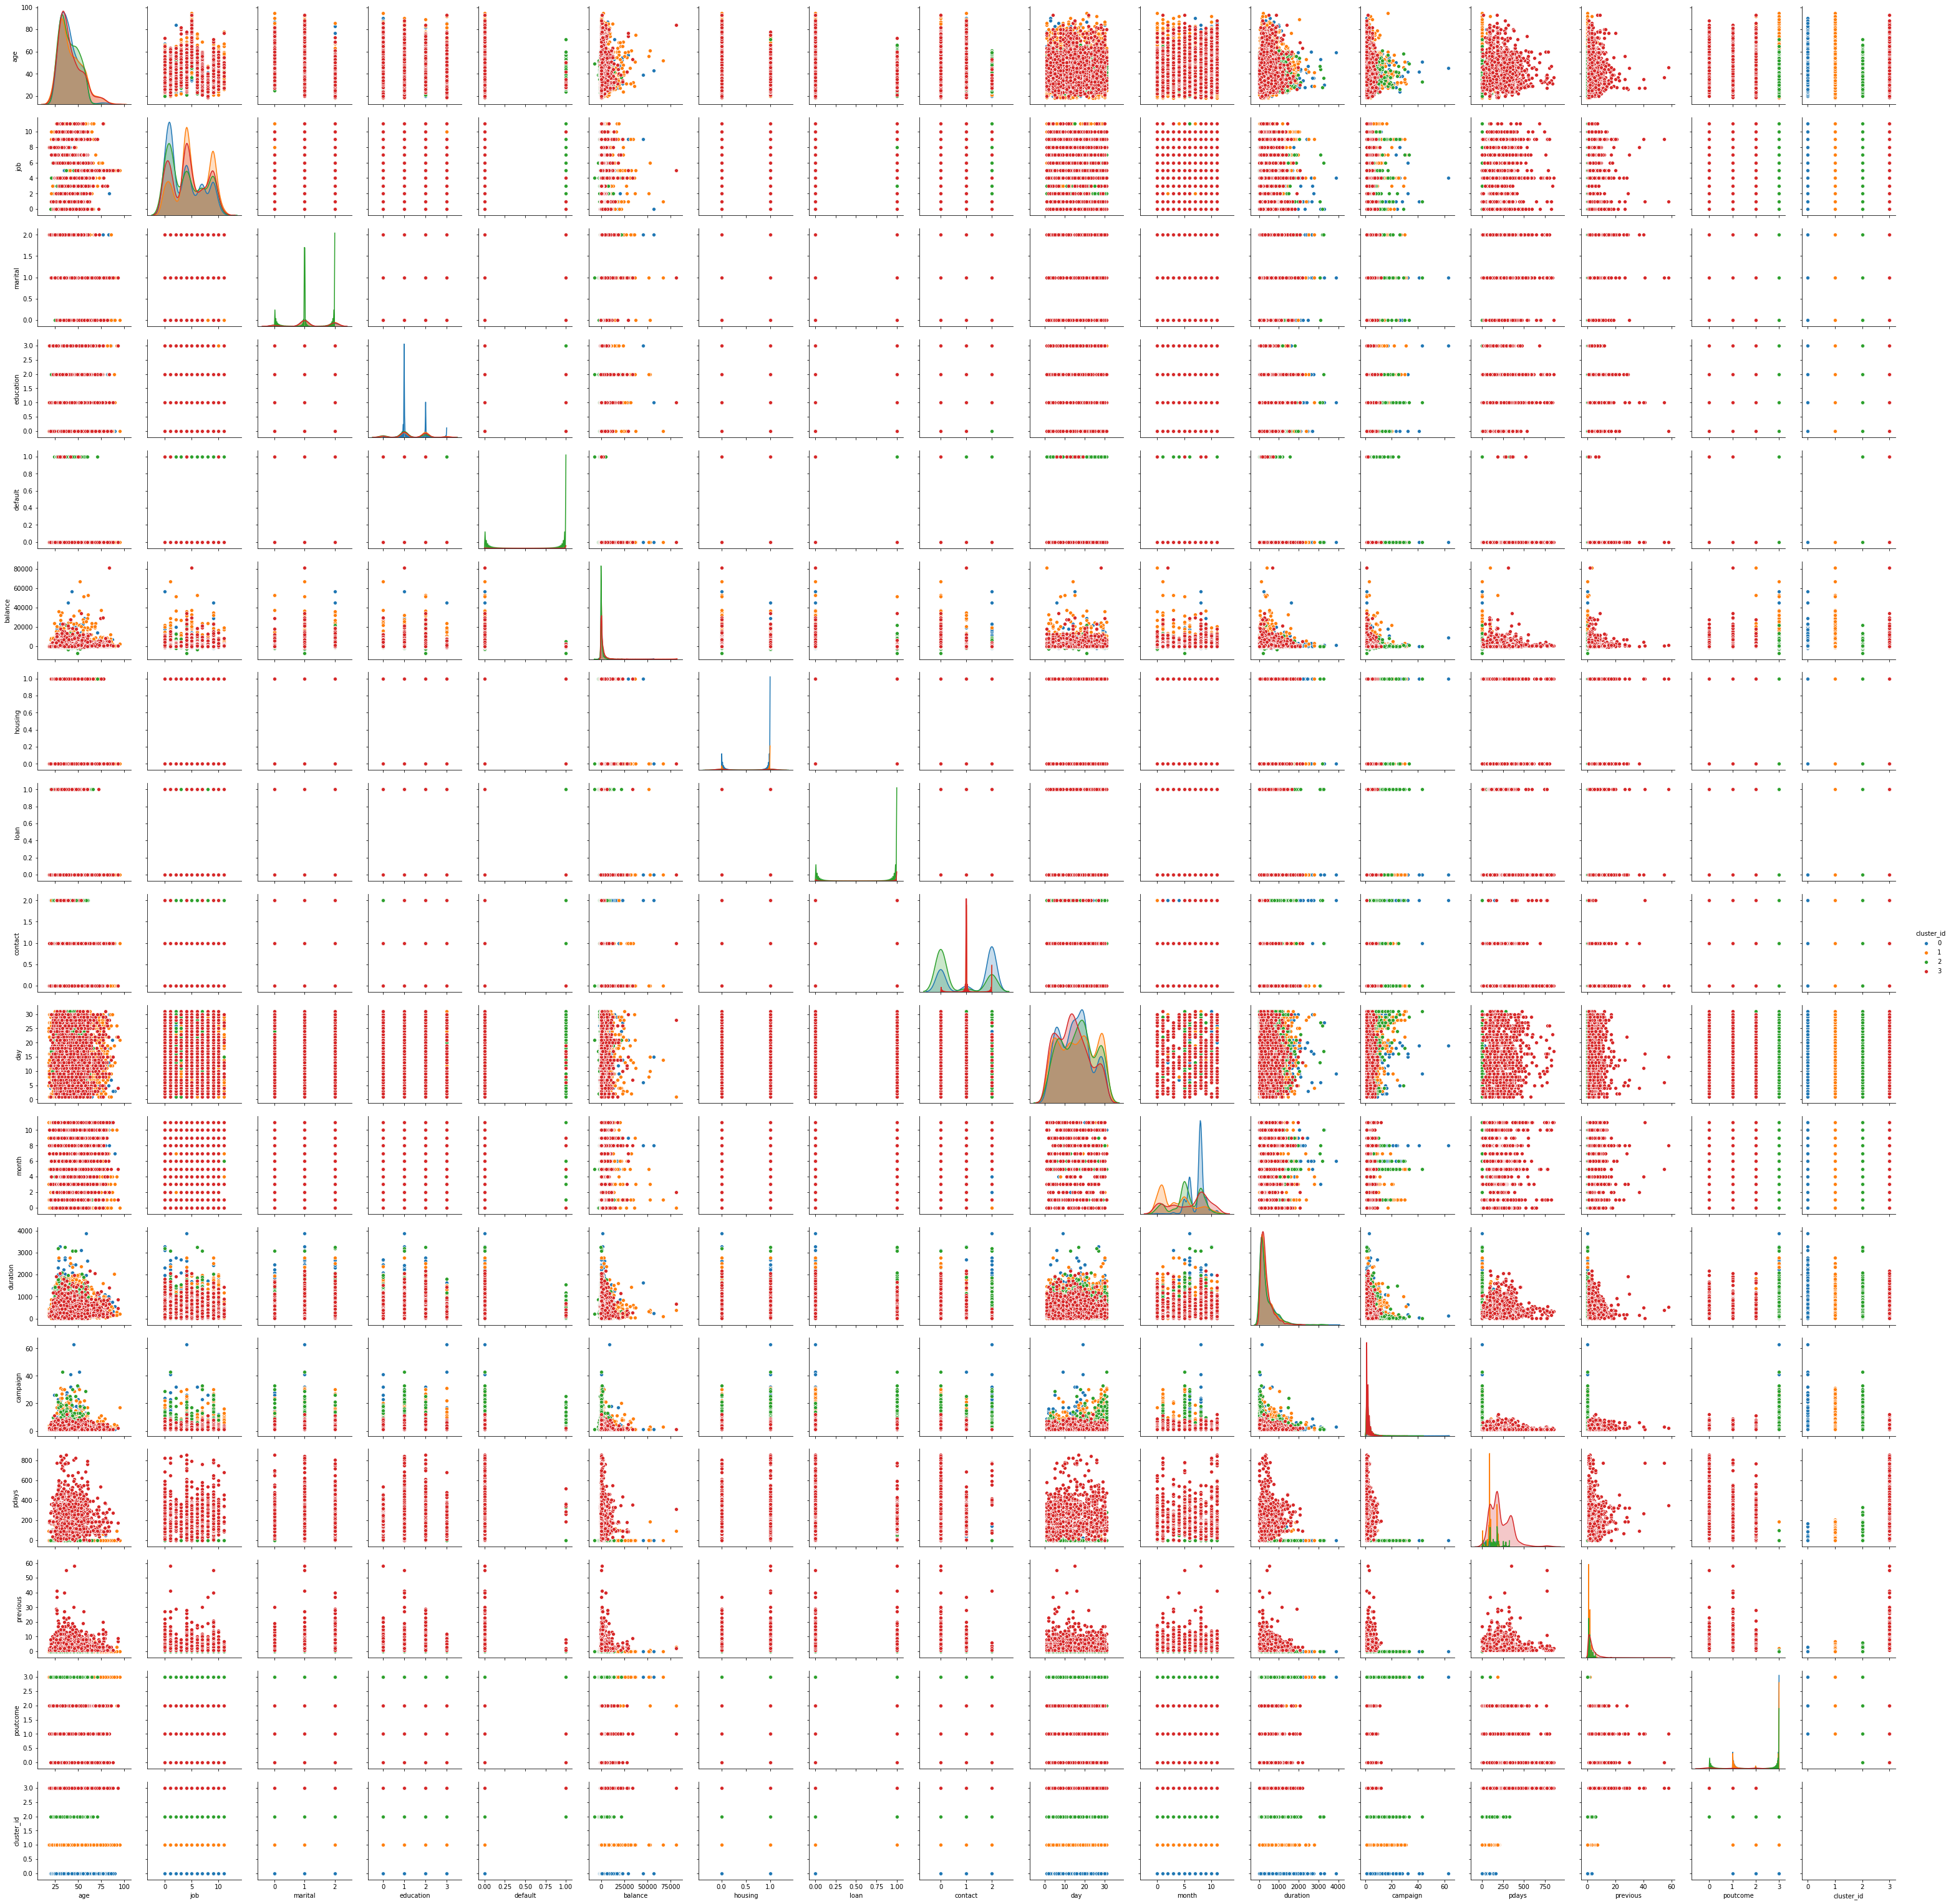

In [32]:
# Note: this may take a while to plot...
sns.pairplot(df_kmeans, hue="cluster_id")

# doubleclick to zoom

In [33]:
# Repeat the same with agc (cluster_ag)
# Try different ks to see the distribution of features across k

## Decision Tree

In [34]:
target = 'deposit'
features = df.columns[df.columns != target]

X = df[features]
y = df[target]

In [35]:
# check for imbalance (important for a Decision Tree)
y.value_counts()

0    5873
1    5289
Name: deposit, dtype: int64

No imbalance, go ahead and train a decision tree classifier

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
from sklearn.tree import DecisionTreeClassifier

dtc_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4)

dtc_entropy.fit(X_train, y_train)
dtc_entropy.score(X_test, y_test) # mean accuracy

0.7656753851666069

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1450
           1       0.74      0.79      0.76      1341

   micro avg       0.77      0.77      0.77      2791
   macro avg       0.77      0.77      0.77      2791
weighted avg       0.77      0.77      0.77      2791



[Text(33,0.5,'Truth'), Text(0.5,15,'Predicted')]

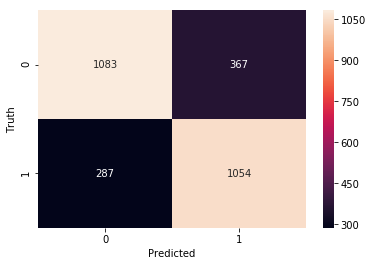

In [38]:
# Apply classification metrics
from sklearn.metrics import classification_report, confusion_matrix

y_pred = dtc_entropy.predict(X_test)

print(classification_report(y_test, y_pred))

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
ax.set(xlabel='Predicted', ylabel='Truth')

In [39]:
# Visualise the decision tree

# conda install python-graphviz
from sklearn.tree import export_graphviz
import graphviz

In [40]:
# to run this cell multiple times, need to close the pdf file first
filename = 'dtc_bank_marketing_entropy.dot'
export_graphviz(dtc_entropy,
                out_file=filename,
                feature_names=features,
                class_names=y_encoder.classes_,
                filled=True,
                rounded=True)

source = graphviz.Source.from_file(filename)
source.render(view=True)

'dtc_bank_marketing_entropy.dot.pdf'

### Applying clusters to Supervised Learning

Train a decision tree using any set of clusters from earlier workshop.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, clusters_kmeans, random_state=42)

In [42]:
dtc_entropy_kmeans = DecisionTreeClassifier(criterion='entropy', max_depth=4)

dtc_entropy_kmeans.fit(X_train, y_train)
dtc_entropy_kmeans.score(X_test, y_test) # mean accuracy

0.861698316015765

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       785
           1       0.88      0.75      0.81      1060
           2       1.00      0.95      0.97       312
           3       0.94      0.91      0.92       634

   micro avg       0.86      0.86      0.86      2791
   macro avg       0.89      0.89      0.89      2791
weighted avg       0.87      0.86      0.86      2791



[Text(33,0.5,'Truth'), Text(0.5,15,'Predicted')]

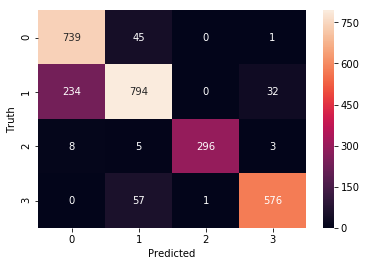

In [43]:
y_pred = dtc_entropy_kmeans.predict(X_test)

print(classification_report(y_test, y_pred))

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
ax.set(xlabel='Predicted', ylabel='Truth')

In [44]:
# to run this cell multiple times, need to close the pdf file first
filename = 'dtc_bank_marketing_entropy_kmeans.dot'
export_graphviz(dtc_entropy_kmeans,
                out_file=filename,
                feature_names=features,
                filled=True,
                rounded=True)

source = graphviz.Source.from_file(filename)
source.render(view=True)

'dtc_bank_marketing_entropy_kmeans.dot.pdf'

### Deployment and Predictions

Inventory (what's needed for prediction):
1. Label encoders for each feature
2. Label encoder for the target
3. Model

In [45]:
import pickle

pickle.dump(encoders, open('03_bank_marketing_feature_encoders.pickle', 'wb'))
pickle.dump(y_encoder, open('03_bank_marketing_target_encoder.pickle', 'wb'))
pickle.dump(dtc_entropy, open('03_bank_marketing_dtc_entropy.pickle', 'wb'))

In [46]:
# load model in deployment
from sklearn.metrics import accuracy_score

encoders1 = pickle.load(open('03_bank_marketing_feature_encoders.pickle', 'rb'))
y_encoder1 = pickle.load(open('03_bank_marketing_target_encoder.pickle', 'rb'))
dtc1 = pickle.load(open('03_bank_marketing_dtc_entropy.pickle', 'rb'))

# imagine we have test data
# ideally this should come from a different set
df_test = pd.read_csv('../../data/bank-marketing/bank.csv').sample(n=100)

# label encode features
for f in encoders.keys():
    df_test[f] = encoders1[f].transform(df_test[f])

In [47]:
# predict
test_data = df_test[features]
truth = df_test[target].values

predictions = dtc1.predict(test_data)

# label decode target
predictions = y_encoder1.inverse_transform(predictions)

print('Truth', truth)
print('Predictions', predictions)
print('Accuracy', accuracy_score(truth, predictions))

Truth ['no' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'yes'
 'no' 'no' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'no' 'yes'
 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'yes'
 'yes' 'yes' 'no' 'no' 'no' 'no' 'yes' 'no' 'yes' 'no' 'yes' 'no' 'yes'
 'yes' 'no' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'yes'
 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'yes' 'no'
 'no' 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'yes'
 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'yes' 'yes']
Predictions ['no' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes'
 'no' 'no' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'no' 'yes'
 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'no' 'yes' 'yes'
 'yes' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'yes'
 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'no' 'yes' 'yes'
 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'yes' '

In [49]:
# show predictions
df_test['predictions'] = predictions

# label decode features
for f in encoders.keys():
    df_test[f] = encoders1[f].inverse_transform(df_test[f])

df_test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,predictions
7790,47,technician,married,secondary,no,1571,yes,no,cellular,11,may,261,1,369,2,failure,no,no
9656,31,management,single,tertiary,no,713,no,no,cellular,28,aug,162,1,-1,0,unknown,no,no
4845,34,management,married,tertiary,no,8000,no,no,cellular,12,feb,291,1,260,2,failure,yes,yes
1905,31,admin.,single,tertiary,no,355,yes,no,cellular,12,may,609,1,-1,0,unknown,yes,yes
9350,57,management,married,tertiary,no,0,yes,no,cellular,21,nov,67,1,-1,0,unknown,no,no
10426,60,housemaid,divorced,primary,no,1412,no,no,cellular,22,jul,127,4,-1,0,unknown,no,no
1930,42,blue-collar,single,secondary,no,1080,yes,yes,cellular,13,may,951,3,370,4,failure,yes,yes
5636,29,services,single,secondary,no,1008,yes,no,unknown,23,may,426,9,-1,0,unknown,no,no
10273,55,self-employed,married,secondary,no,12159,yes,no,cellular,20,nov,142,2,174,2,failure,no,yes
1153,40,management,married,tertiary,no,1308,no,no,telephone,3,feb,1776,2,-1,0,unknown,yes,yes
